# Clean and Analyze TueDB dataset
- We only take mhc_class I and convert all_hla_alleles_donor into list of strings
- We remove modifications from the peptide sequence

### Libraries

In [2]:
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr


### Read in original database

In [3]:
PATH_TO_TUEDB = '../../DATA/db_dump_311023.tsv'

df1 = pd.read_csv(PATH_TO_TUEDB, sep='\t')
df1.head()

,peptide_sequence,donor_code,all_hla_alleles_donor,mhc_class,peptide_modifications
0,GMWGGAMLGV,ZH909,A*02:01;A*29:02;B*44:02;B*44:03;C*05:01;C*16:01,I,"[{""2"" : ""M(Oxidation""}, {""7"" : ""M(Oxidation""}]"
1,ALLSRLEQI,ZH909,A*02:01;A*29:02;B*44:02;B*44:03;C*05:01;C*16:01,I,NaN
2,FIDASRLVY,ZH909,A*02:01;A*29:02;B*44:02;B*44:03;C*05:01;C*16:01,I,NaN
3,ALESFLKQV,ZH909,A*02:01;A*29:02;B*44:02;B*44:03;C*05:01;C*16:01,I,NaN
4,QILDGVHYL,ZH909,A*02:01;A*29:02;B*44:02;B*44:03;C*05:01;C*16:01,I,NaN


### Process tuedb_df for this usecase:
- Only MHC Class 1
- 4-digit typing
- Has to have either one of A, B, or C alleles

In [4]:
tuedb_df = df1.copy()

def check_alleles(alleles_string: str) -> list:
    """
    Checks a semicolon-separated string of allele entries for validity and returns a list of valid alleles.

    Args:
        alleles_string (str): Alleles of a donor in a string separated by ';'

    Returns:
        list: List with valid alleles of a donor (no 2-digit alleles)
    """
    if ";" in alleles_string:
        allele_list = []
        for allele in alleles_string.split(';'):
            if re.match(r'[A-C]\*\d{2}:\d{2}', allele):
                allele = allele.replace(':', '')
                allele = allele.replace('*', '')
                if len(allele) > 5:
                    allele = allele[:5]
                allele_list.append(allele)
        return allele_list
    else:
        return [alleles_string]

filter_out_donors = {}

donors_before = set(tuedb_df['donor_code'].unique())
tuedb_df = tuedb_df[tuedb_df['mhc_class'] == 'I']
donors_after = set(tuedb_df['donor_code'].unique())
filter_out_donors['only_mhc_class_II_entries'] = list(donors_before-donors_after)

#get all donors that have nan in all_hla_alleles_donor
donors_before = set(tuedb_df['donor_code'].unique())
tuedb_df = tuedb_df[~tuedb_df['all_hla_alleles_donor'].isna()]
donors_after = set(tuedb_df['donor_code'].unique())
filter_out_donors['all_hla_alleles_donor_empty'] = list(donors_before-donors_after)

tuedb_df['all_hla_alleles_donor'] = tuedb_df['all_hla_alleles_donor'].apply(check_alleles)

#throw out all donors that have only mhc II alleles in all_hla_alleles_donor column but have mhc class = I
donors_before = set(tuedb_df['donor_code'].unique())
tuedb_df = tuedb_df[tuedb_df['all_hla_alleles_donor'].apply(lambda x: len(x) > 0)]
donors_after = set(tuedb_df['donor_code'].unique())
filter_out_donors['rough_typing'] = list(donors_before-donors_after)

tuedb_df['no_alleles'] = tuedb_df['all_hla_alleles_donor'].str.len()

#throw out all donors that have no A or B or C alleles
donors_before = set(tuedb_df['donor_code'].unique())
tuedb_df = tuedb_df[tuedb_df['all_hla_alleles_donor'].apply(lambda x: ''.join(x).count('A') > 0 and ''.join(x).count('B') > 0 and ''.join(x).count('C') > 0)]
donors_after = set(tuedb_df['donor_code'].unique())
filter_out_donors['no_ABC_alleles'] = list(donors_before-donors_after)

print(filter_out_donors)


{'only_mhc_class_II_entries': ['ZH444', '1134-17', 'KK1', '1052-17', 'ProCa-L06', 'CLL02001', 'BrCa37', 'D283', 'CLL01027', 'KC67', 'CLL14', '1092-16', 'OvN48', 'OvN45', 'CLL09', 'CLL01012', 'ProCa-308', 'RCC1438', 'ZH862', 'Plakki0012', 'HNSCC_37273', 'PC10', 'MTB012SARC_4', 'PC3', 'AML01', 'Plakki0034', 'CLL01010', 'D341', 'ZH483', 'CLL65', 'Plakki0016', 'RCC1428'], 'all_hla_alleles_donor_empty': ['MTB005KC', 'MTB012SARC_5', 'MaN153', 'N5-06', 'OvCa172', 'LCa115', 'OvCa277', 'PC13', 'OvCa136', 'OvCa270', 'RCC171', 'OvN47', 'OvN278', 'OvN38', 'OvN44', 'KC97', 'LCa110', 'HCC035', 'HCC030', 'OvCa268', 'Ben6', 'BrCa2', 'BrCa18', 'OvN46', 'MaN157', 'OvCa252', 'MaCa117', 'GaCa23', 'OvCa261', 'OvN52', 'OvCa259', 'OvCa251', 'OvCa265', 'KC80', 'OvN42', 'BrCa44', 'BrCa25', 'OvCa186', 'ZH1015', 'HCC042', 'BPH6', 'GBM483', 'ZH442', 'BrCa03', 'OvCa263', 'BrCa55', 'LCa125', 'ZH511', 'OvN27', 'OvCa163', 'OvN287', 'Zahnd10293640', 'PC12', 'ZH1019', 'CML70', 'DAOY', 'HNSCC_11013', 'OvCa276', 'BPH5', 

We get this cleaned version of the database:

In [5]:
tuedb_df.head()

,peptide_sequence,donor_code,all_hla_alleles_donor,mhc_class,peptide_modifications,no_alleles
0,GMWGGAMLGV,ZH909,"[A0201, A2902, B4402, B4403, C0501, C1601]",I,"[{""2"" : ""M(Oxidation""}, {""7"" : ""M(Oxidation""}]",6
1,ALLSRLEQI,ZH909,"[A0201, A2902, B4402, B4403, C0501, C1601]",I,NaN,6
2,FIDASRLVY,ZH909,"[A0201, A2902, B4402, B4403, C0501, C1601]",I,NaN,6
3,ALESFLKQV,ZH909,"[A0201, A2902, B4402, B4403, C0501, C1601]",I,NaN,6
4,QILDGVHYL,ZH909,"[A0201, A2902, B4402, B4403, C0501, C1601]",I,NaN,6


Here are some facts about the database:
- 778 donors are available for validation of approaches.
- The average number of peptides per donor is 4338 peptides.

In [6]:
print(f'Number of donors: {len(tuedb_df['donor_code'].unique())}')
#donor_counts = tuedb_df.groupby('donor_code')['peptide_sequence'].count()
#print(f'The average number of peptides per donor is {round(donor_counts.mean(),0):.0f} peptides.')

Number of donors: 778


If not already done, you can convert the df to a csv and work with this PATH_TO_TUEDB continuing forward:

In [7]:
#tuedb_df.to_csv('sb_sump_311023_cleaned.tsv', sep='\t', index=False)

# Plots
### Plot Peptides Per Donor in TueDB

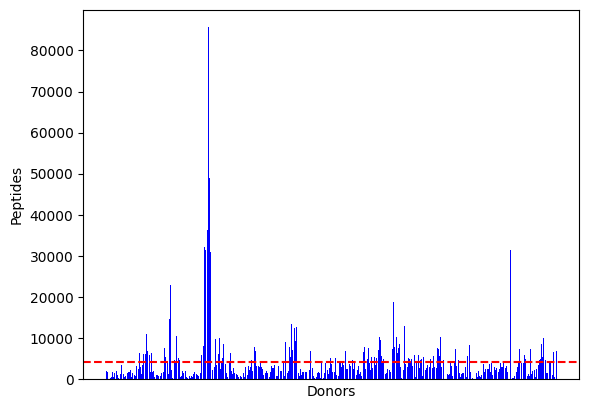

In [8]:
donor_counts = tuedb_df.groupby('donor_code')['peptide_sequence'].count()
plt.bar(donor_counts.index, donor_counts.values, color='blue')
mean = np.mean(donor_counts.values)
mean = int(str(mean).split('.')[0])

plt.axhline(y=mean, color='red', linestyle='--')
plt.xticks([])
plt.xlabel('Donors')
plt.ylabel('Peptides')
#plt.title('Peptides per Donor')
#plt.legend([f'Average at {mean} Peptides', 'Donor'])
plt.show()


### Plot Count Class 1 Alleles per Donor

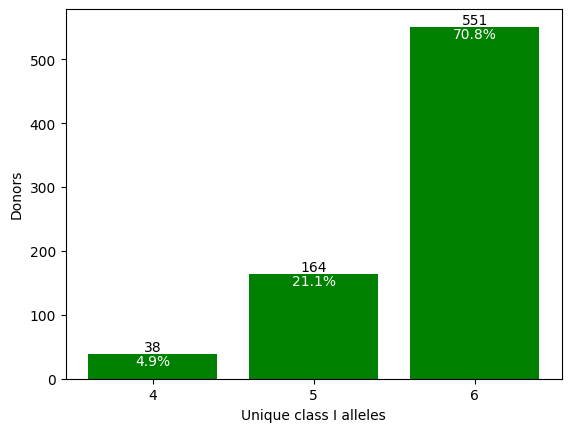

In [9]:
donor_counts = tuedb_df.groupby('donor_code')['no_alleles'].first()
donor_counts = donor_counts.value_counts()
#filter out 3 7 9 counter from donor_counts
donor_counts = donor_counts[donor_counts.index.isin([4,5,6])]

colors = []
for value in donor_counts.index:
    if value == 6:
        colors.append('green')
    else: 
        colors.append('green')
bars = plt.bar(donor_counts.index, donor_counts.values, color=colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, str(round(yval/778*100, 1)) + '%', ha='center', va='top', color='white')
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 1), ha='center', va='bottom')

plt.xticks(donor_counts.index)
#plt.title('Distribution of Class 1 Alleles per Donor')
plt.xlabel('Unique class I alleles')
plt.ylabel('Donors')
plt.show()

### Show allele frequency in TueDB vs. in german population

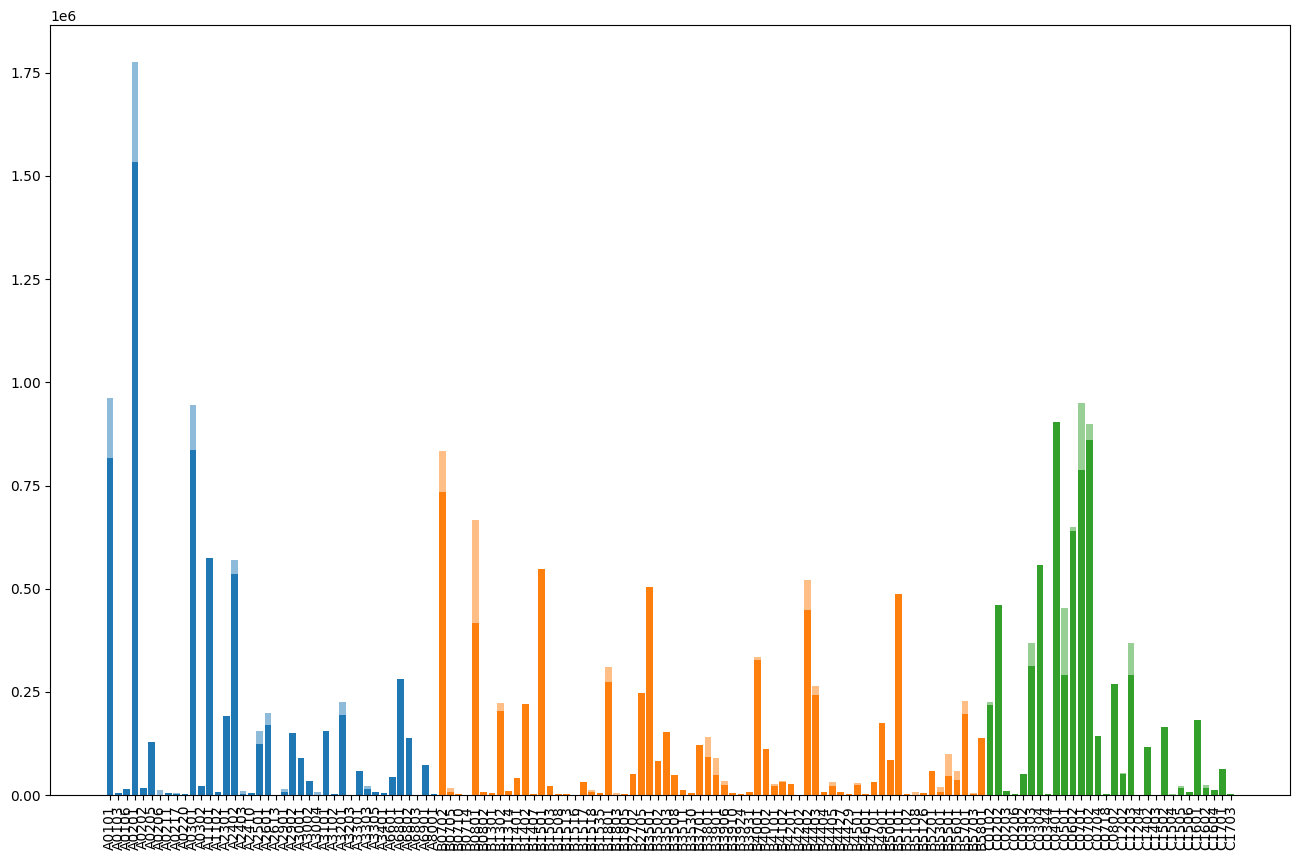

In [10]:
# Explode the lists in the column into separate rows
exploded_df = tuedb_df['all_hla_alleles_donor'].explode().reset_index(drop=True)

allele_list = exploded_df.tolist()
allele_list = dict(Counter(allele_list))
sorted_alleles = sorted(allele_list.keys())

# Get values corresponding to sorted keys
sorted_counts = [allele_list[key] for key in sorted_alleles]
count_a = [allele_list[key] for key in sorted_alleles if key.startswith('A')]
count_b = [allele_list[key] for key in sorted_alleles if key.startswith('B')]
count_c = [allele_list[key] for key in sorted_alleles if key.startswith('C')]

#make colors
colors= []
color_list=['#1f78b4','#ff7f0e','#33a02c']
for allele in sorted_alleles:
    if allele.startswith('A'):
        colors.append(color_list[0])
    elif allele.startswith('B'):
        colors.append(color_list[1])
    elif allele.startswith('C'):
        colors.append(color_list[2])

allele_freq_df = pd.read_csv('../../DATA/dkms_allele_freq_german.tsv', sep='\t')
allele_freq_dict = dict(zip(allele_freq_df['Allele'], allele_freq_df['Allele Frequency']))
all_tuedb_alleles = list(set(list(exploded_df)))

#Edge cases, these alleles are not present in the DKMS set
allele_freq_dict['B*14:07'] = 0
allele_freq_dict['B*44:27'] = 0
allele_freq_dict['C*07:18'] = 0 
allele_freq_dict['C*17:03'] = 0
#reomve * and : from key in allele_freq_dict

y = []
for allele in sorted_alleles:
    allele_name = f'{allele[0]}*{allele[1:3]}:{allele[3:]}'

    if allele.startswith('A'):
        y.append(allele_freq_dict[allele_name]*sum(count_a))
    elif allele.startswith('B'):
        y.append(allele_freq_dict[allele_name]*sum(count_b))
    elif allele.startswith('C'):
        y.append(allele_freq_dict[allele_name]*sum(count_c))

plt.figure(figsize=(16,10))
plt.xticks(rotation=90)
bars_background = plt.bar(sorted_alleles, y, color=colors,alpha=0.5)
bars = plt.bar(sorted_alleles, sorted_counts, color=colors)
y_2 = [0]*len(y)
y_tue = [0]*len(y)
for i,why in enumerate(y):
    if y[i] < sorted_counts[i]:
        y_2[i] = sorted_counts[i]
    y_tue[i] = sorted_counts[i]
        
bars_background2 = plt.bar(sorted_alleles, y_2, color=colors,alpha=0.5)


# Scatter plot of the 2 frequencies of the alleles

Correlation Coefficient: 0.98


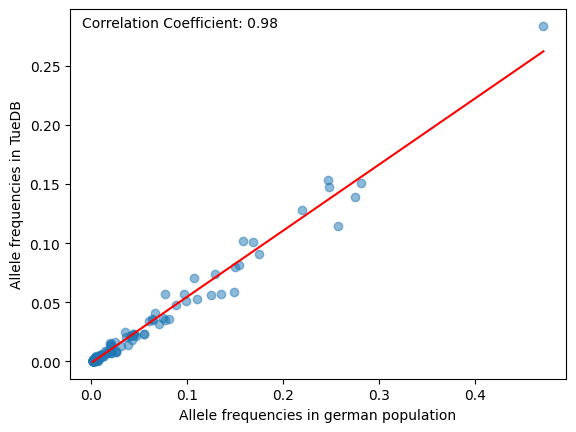

In [11]:
### Prepare allele freuqencies of TueDB
tue = tuedb_df.copy()
tue = tue.groupby('donor_code').first().reset_index()
number_of_donors = len(tue['donor_code'].unique())
exploded_df = tue['all_hla_alleles_donor'].explode().reset_index(drop=True)

allele_list = exploded_df.tolist()
allele_list = dict(Counter(allele_list))
sorted_alleles = sorted(allele_list.keys())
for key in allele_list:
    allele_list[key] = allele_list[key]/number_of_donors

### Prepare allele freuqency of German population
allele_freq_df = pd.read_csv('../../DATA/dkms_allele_freq_german.tsv', sep='\t')
allele_freq_dict = dict(zip(allele_freq_df['Allele'], allele_freq_df['Allele Frequency']))
all_tuedb_alleles = list(set(list(exploded_df)))

#Edge cases, these alleles are not present in the DKMS set
allele_freq_dict['B*14:07'] = 0
allele_freq_dict['B*44:27'] = 0
allele_freq_dict['C*07:18'] = 0 
allele_freq_dict['C*17:03'] = 0

allele_freq = {}
for key in allele_freq_dict:
    allele_freq[key.replace('*', '').replace(':', '')] = allele_freq_dict[key]


### Generate x, y values for scatter plot
keys = set(allele_list.keys()).intersection(allele_freq.keys())

allele_list_values = []
allele_freq_values = []
for key in keys:
    if key in allele_list and key in allele_freq:
        allele_list_values.append(allele_list[key])
        allele_freq_values.append(allele_freq[key])
    elif key in allele_list:
        allele_list_values.append(allele_list[key])
        allele_freq_values.append(0)
    elif key in allele_freq:
        allele_list_values.append(0)
        allele_freq_values.append(allele_freq[key])
    else:
        allele_list_values.append(0)
        allele_freq_values.append(0)

### Plot
plt.scatter(allele_list_values, allele_freq_values, alpha=0.5)
plt.xlabel('Allele frequencies in german population')
plt.ylabel('Allele frequencies in TueDB')

# Calculate the slope and y-intercept of the line of best fit
slope, intercept = np.polyfit(allele_list_values, allele_freq_values, 1)

x_line = np.linspace(min(allele_list_values), max(allele_list_values), 100)
y_line = slope * x_line + intercept

plt.plot(x_line, y_line, color='red', label=f'regression line')

correlation_coefficient, _ = pearsonr(y, y_tue)
plt.text(0.025, 0.95, f'Correlation Coefficient: {correlation_coefficient:.2f}', transform=plt.gca().transAxes)
print(f'Correlation Coefficient: {correlation_coefficient:.2f}')


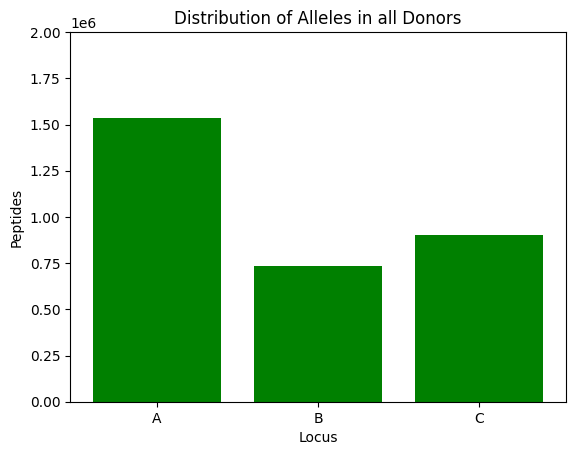

In [12]:
exploded_df = tuedb_df['all_hla_alleles_donor'].explode().reset_index(drop=True)

# Convert the resulting Series to a list
allele_list = exploded_df.tolist()
allele_list = Counter(allele_list)

sorted_alleles = sorted(allele_list.keys())
# Get values corresponding to sorted keys
sorted_counts = [allele_list[key] for key in sorted_alleles]
count_a = [allele_list[key] for key in sorted_alleles if key.startswith('A')]
count_b = [allele_list[key] for key in sorted_alleles if key.startswith('B')]
count_c = [allele_list[key] for key in sorted_alleles if key.startswith('C')]

sorted_alleles = [a[0] for a in sorted_alleles]

plt.ylim(0, 2000000)
bars = plt.bar(sorted_alleles, sorted_counts, color='green')

plt.title('Distribution of Alleles in all Donors')
plt.ylabel('Peptides')
plt.xlabel('Locus')
plt.show()
